In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage.transform import rescale

from sladsnet.input_params import ERDInputParams, GeneralInputParams, SampleParams
from sladsnet.code.measurement_interface import TransmissionSimulationMeasurementInterface, ExperimentMeasurementInterface
from sladsnet.code.erd import SladsSklearnModel
from sladsnet.code.results import Result
from sladsnet.code.base import ExperimentalSample, Sample
from sladsnet.code.sampling import run_sampling
from sladsnet.code.utils import renormalize

In [3]:
from skimage.metrics import structural_similarity, mean_squared_error

from readMDA import readMDA

In [4]:
cm = mpl.cm.viridis.copy()
#cm.set_bad('black')
cnorm = mpl.colors.LogNorm

In [5]:
def clean_and_normalize(x):
    x = np.nan_to_num(x, nan=0, posinf=0, neginf=0)
    x = (x - x.min()) / (x.max() - x.min())
    return x
    

In [6]:
C_VALUE = 2
train_base_path = Path.cwd().parent.parent / 'ResultsAndData/TrainingData/cameraman/'
erd_model = SladsSklearnModel(load_path=train_base_path / f'c_{C_VALUE}/erd_model_relu.pkl')

In [7]:
exp_data = np.load('coarsescan1.npy')

In [8]:
xrf = np.swapaxes(np.swapaxes(exp_data[4,::-1,::-1].reshape(6,4,100,100),1,2),1,3).reshape(600,400)[:,::-1]
int1 = np.swapaxes(np.swapaxes(exp_data[5,::-1,::-1].reshape(6,4,100,100),1,2),1,3).reshape(600,400)[:,::-1]

In [9]:
xrf_rescaled = np.random.poisson(rescale(xrf, 0.5))
int_rescaled = np.random.poisson(rescale(int1, 0.5))
normalized_int = renormalize(int_rescaled)
normalized_combined = renormalize(xrf_rescaled**0.5 * int_rescaled**0.5)

In [10]:
xrf_threshold = xrf_rescaled < 10

In [11]:
int_rescaled.shape, int1.shape

((300, 200), (600, 400))

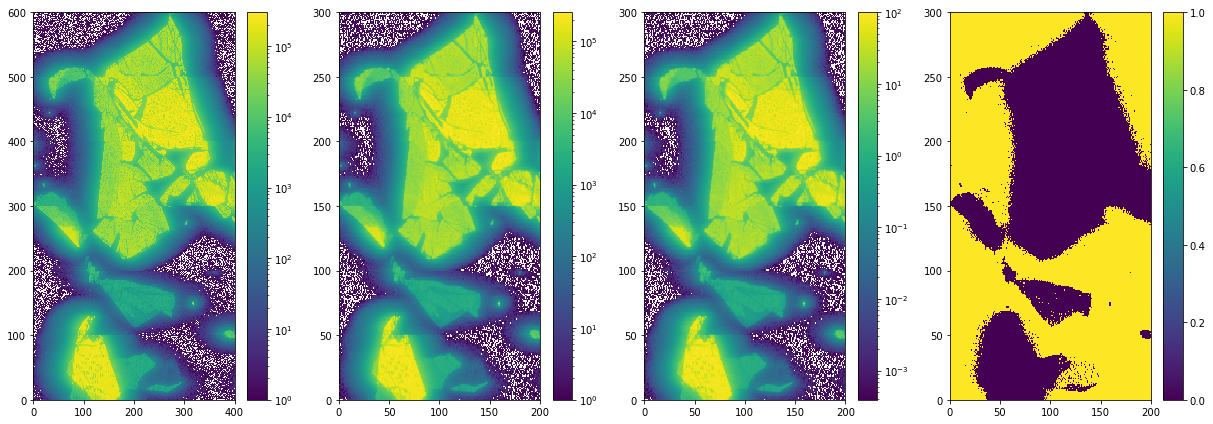

In [12]:
fig, axs = plt.subplots(1, 4, figsize=[17,6])
plt.subplot(1,4,1)
plt.pcolormesh(int1, cmap=cm, norm=cnorm())
plt.colorbar()
plt.subplot(1,4,2)
plt.pcolormesh(int_rescaled, cmap=cm, norm=cnorm())
plt.colorbar()
plt.subplot(1,4,3)
plt.pcolormesh(normalized_int, cmap=cm, norm=cnorm())
plt.colorbar()
plt.subplot(1,4,4)
plt.pcolormesh(xrf_threshold, cmap=cm)#, norm=cnorm())
plt.colorbar()
plt.tight_layout()

In [13]:
inner_batch_size = 100
initial_scan_points_num = 500

stop_ratio = 0.3
store_results_percentage = 1

affected_neighbors_window_min = 5
affected_neighbors_window_max = 15
full_erd_recalculation_frequency = 1

In [14]:
params_erd = ERDInputParams(c_value=C_VALUE,
                            full_erd_recalculation_frequency=full_erd_recalculation_frequency,
                            affected_neighbors_window_min=affected_neighbors_window_min,
                            affected_neighbors_window_max=affected_neighbors_window_max)
params_gen = GeneralInputParams()

sample_params = SampleParams(image_shape=(300, 200),
                             inner_batch_size=inner_batch_size,
                             initial_scan_points_num=initial_scan_points_num,
                             initial_scan_ratio=None,
                             stop_ratio=stop_ratio,
                             random_seed=11)


#measurement_interface = ExperimentMeasurementInterface()#'instructions.csv', num_initial_idxs= 2000)
#interface.perform_measurement(sample_params.initial_idxs)
measurement_interface = TransmissionSimulationMeasurementInterface(image=normalized_int)

In [15]:
np.savetxt('instructions_000.csv', sample_params.initial_idxs, delimiter=',', fmt='%10d')

In [16]:
sample = Sample(sample_params=sample_params,
                general_params=params_gen,
                erd_params=params_erd,
                measurement_interface=measurement_interface,
                erd_model=erd_model)
results = Result()

In [17]:
run_sampling(sample, results=results, results_frequency_step=1, results_frequency_percentage=0, 
             disable_progress_bar=False, debug=False, indices_to_actually_measure=50)

Reached the stopping ratio set in the sample parameters. Stopping scan.


(<sladsnet.code.results.Result at 0x106355f90>, 350)

In [18]:
erds = results.outputs.erds
total_erds = np.sum(erds, axis=(1,2))

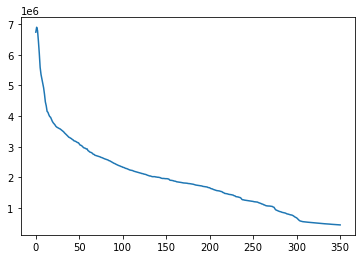

In [19]:
plt.plot(total_erds)

In [20]:
total_erds

array([6737827.5 , 6898440.5 , 6790500.  , 6449708.  , 6054312.  ,
       5590781.5 , 5357381.5 , 5208889.  , 5057642.5 , 4921952.  ,
       4712497.  , 4460966.  , 4334554.5 , 4152271.8 , 4120556.  ,
       4041649.5 , 3983473.5 , 3960201.  , 3892708.5 , 3828591.5 ,
       3781097.8 , 3750222.8 , 3714431.  , 3668046.  , 3641107.  ,
       3624341.  , 3605419.5 , 3591391.5 , 3579001.5 , 3555451.5 ,
       3529784.8 , 3507522.  , 3486116.5 , 3451170.8 , 3425591.2 ,
       3396109.5 , 3368537.5 , 3339052.8 , 3308270.5 , 3297491.  ,
       3276255.5 , 3262908.2 , 3234869.2 , 3219831.2 , 3189009.8 ,
       3183263.2 , 3170095.5 , 3151417.2 , 3134004.8 , 3128001.  ,
       3092641.  , 3052737.8 , 3044184.5 , 3025607.  , 2994119.8 ,
       2967123.2 , 2958462.  , 2946288.5 , 2927442.  , 2928491.8 ,
       2873665.2 , 2854593.8 , 2827310.2 , 2815247.2 , 2806124.5 ,
       2785659.  , 2754934.  , 2747651.  , 2721161.2 , 2712717.2 ,
       2703370.  , 2698432.  , 2688475.2 , 2680043.  , 2666850

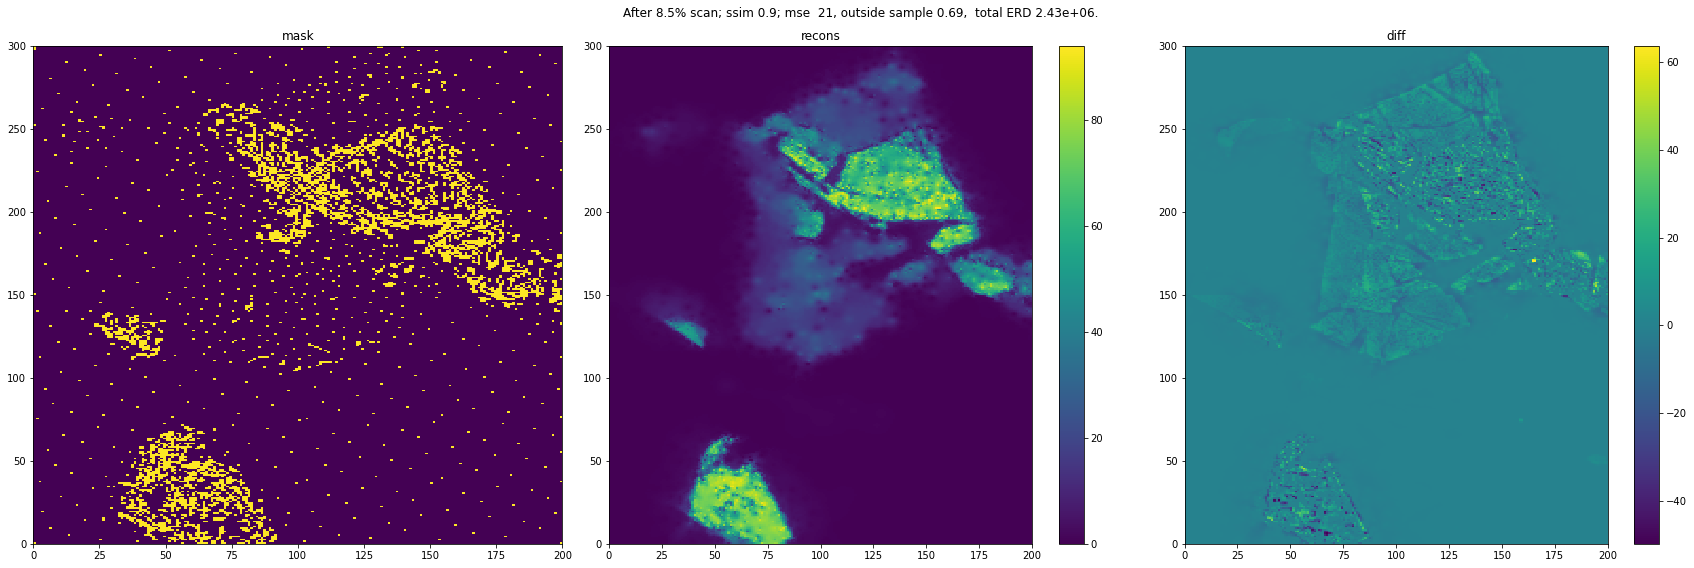

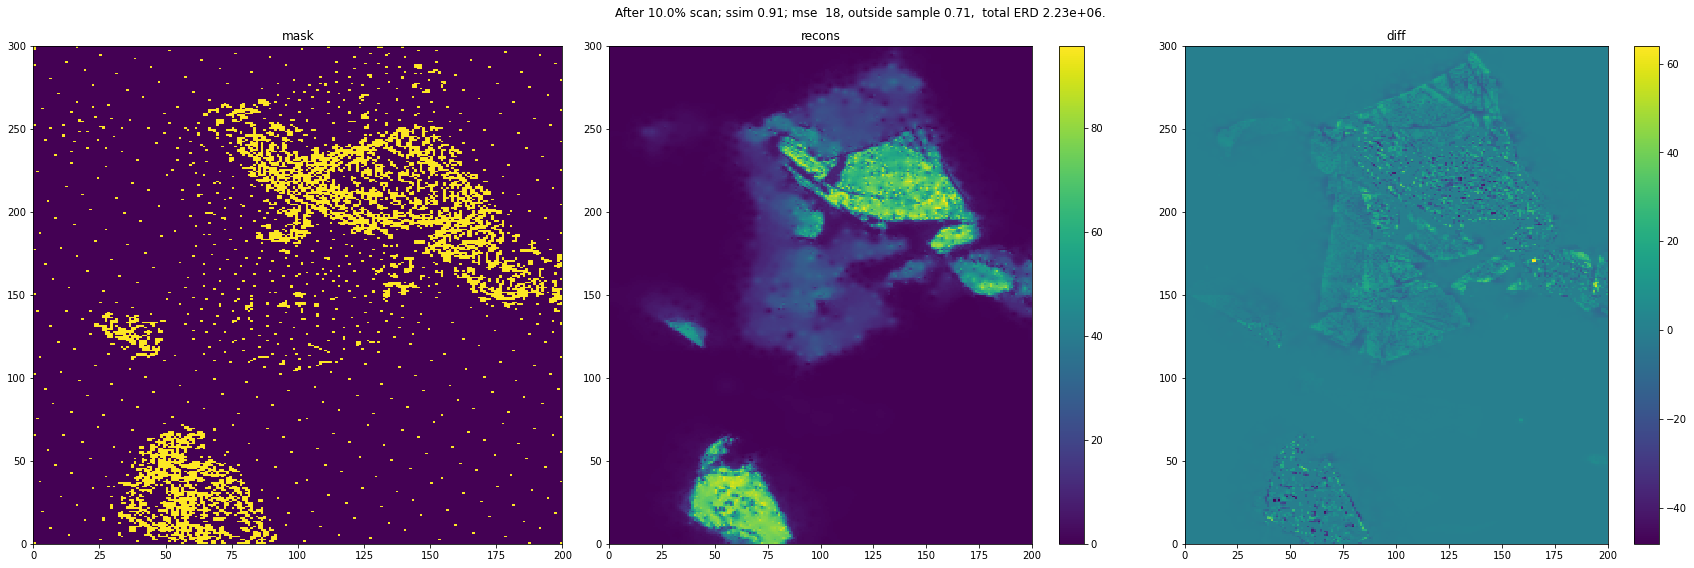

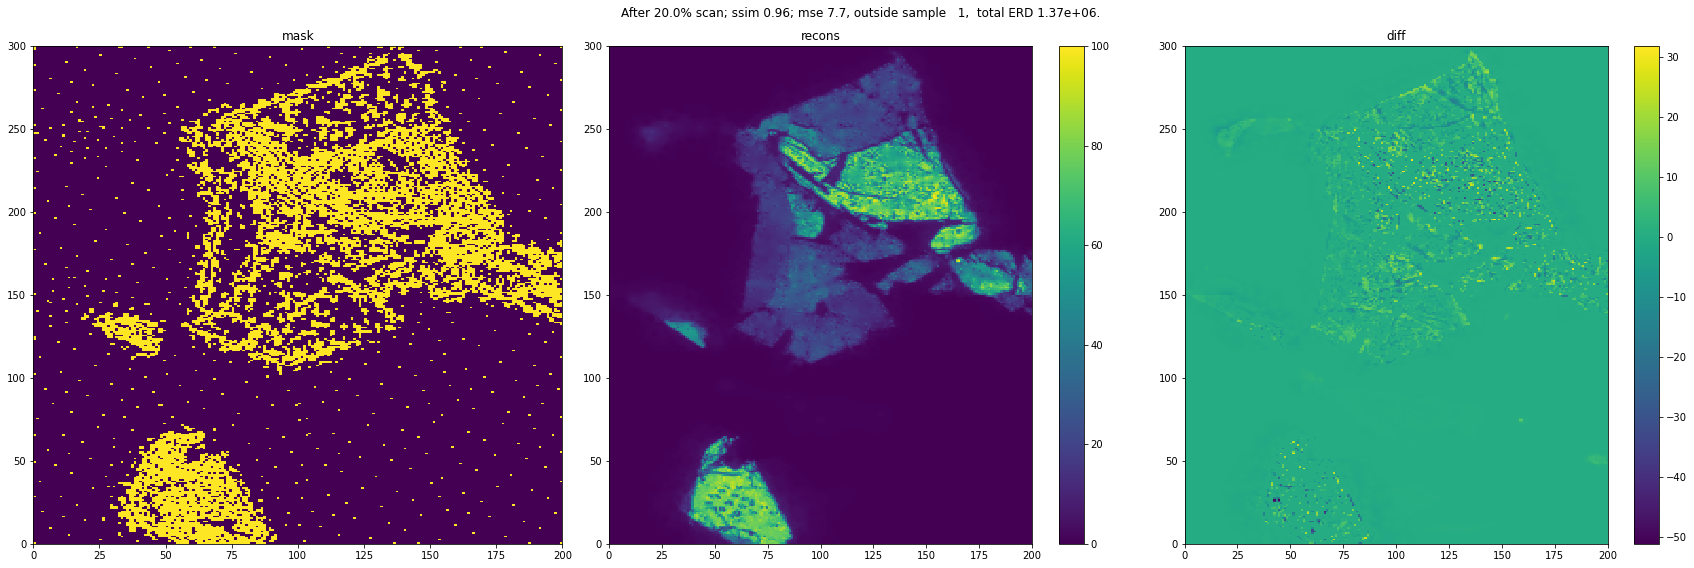

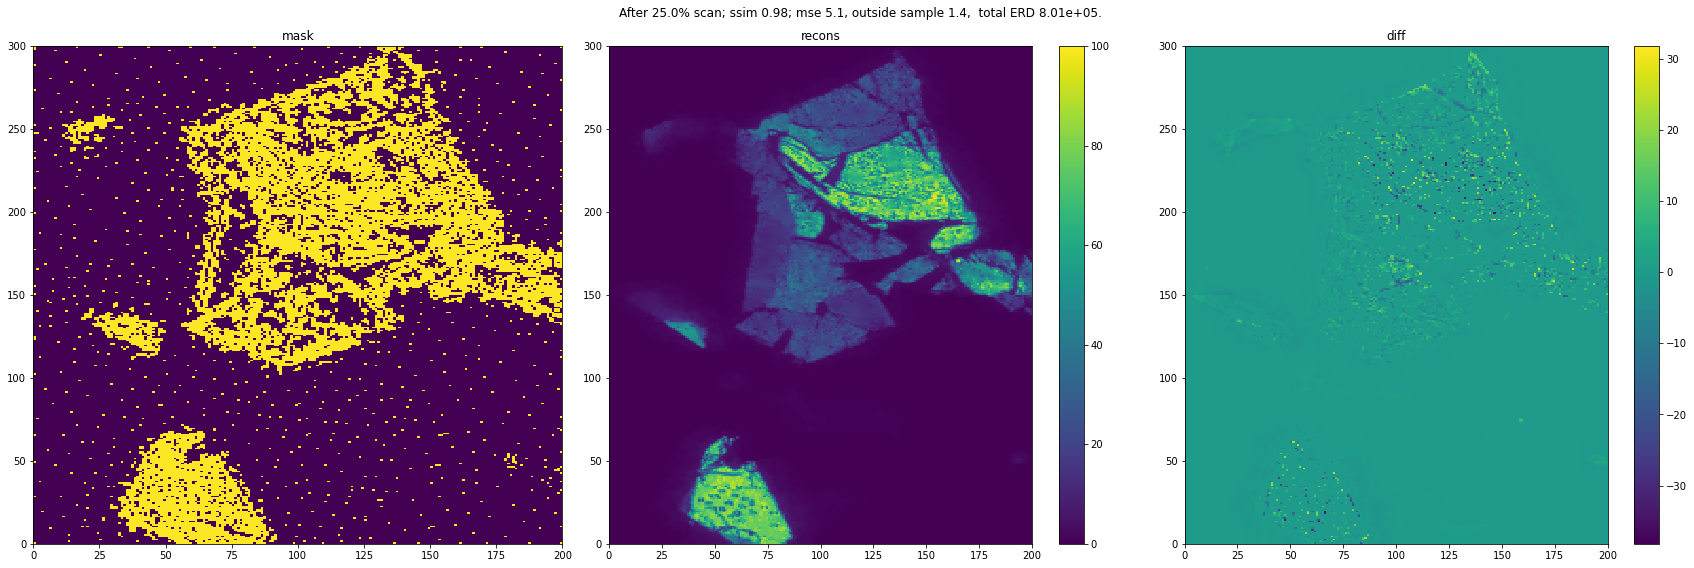

In [22]:
for i in range(results.size):
    #scan_ratio = (i + 1) * 0.1
    #percent = int(scan_ratio * 100)
    
    #if percent >= results.size:
    #    percent = results.size - 1
    
    actual_percent = round(results.outputs.masks[i].sum() / results.outputs.masks[i].size * 100, 2)
    percent_outside_sample = results.outputs.masks[i][xrf_threshold].sum() / results.outputs.masks[i].size * 100
    percent = actual_percent
    #print(actual_percent)
    if percent not in [8.5, 10, 20, 25]: continue
    
    
    fig, axs = plt.subplots(1, 3, figsize=[24, 8])
    plt.subplot(1, 3, 1)
    plt.pcolormesh(results.outputs.masks[i])
    plt.title('mask')
    plt.subplot(1, 3, 2)
    plt.pcolormesh(results.outputs.recons[i], cmap=cm)
    plt.colorbar()
    plt.title('recons')
    plt.subplot(1, 3, 3)
    err = measurement_interface.image - results.outputs.recons[i]
    plt.pcolormesh(measurement_interface.image - results.outputs.recons[i])
    plt.colorbar()
    plt.title('diff')
    
    ssim = structural_similarity(results.outputs.recons[i], measurement_interface.image, 
                                 data_range=255)
    mse = mean_squared_error(results.outputs.recons[i], measurement_interface.image)
    erd_this = results.outputs.erds[i].sum()
    
    plt.suptitle(f'After {actual_percent}% scan; ssim {ssim:3.2g}; mse {mse:3.2g}, outside sample {percent_outside_sample:3.2g}, '\
                 f' total ERD {erd_this:4.3g}.')
    plt.tight_layout()
    plt.show()


In [26]:
results.outputs.recons[-1]

array([[0.0000000e+00, 2.9601628e-04, 1.1620892e-03, ..., 4.7609067e-04,
        7.2667835e-04, 7.8525295e-04],
       [2.5602104e-04, 5.3982646e-04, 1.0774471e-03, ..., 5.1160937e-04,
        7.0876448e-04, 7.6831406e-04],
       [8.3223195e-04, 1.0416635e-03, 1.3750303e-03, ..., 6.1195396e-04,
        7.2889519e-04, 7.8580721e-04],
       ...,
       [4.1360565e-04, 4.3679366e-04, 4.9664546e-04, ..., 2.8424698e-04,
        2.1580771e-04, 1.7726624e-04],
       [3.9262648e-04, 4.1344704e-04, 4.7012808e-04, ..., 1.9354215e-04,
        9.3145005e-05, 4.6841684e-05],
       [3.9262648e-04, 4.1130238e-04, 4.6249988e-04, ..., 1.3961934e-04,
        4.3033775e-05, 0.0000000e+00]], dtype=float32)

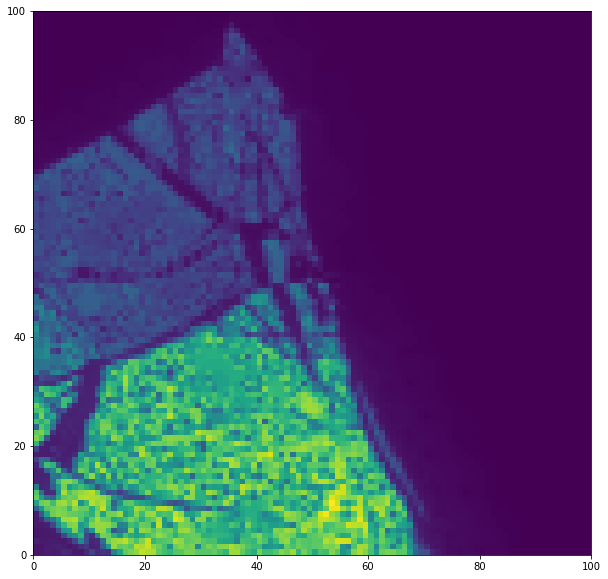

In [28]:
plt.figure(figsize=[10,10])
plt.pcolormesh(results.outputs.recons[-1][200:300,100:200])
plt.show()